In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    @staticmethod
    def forward(ctx, input, scale):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method. We also need to pass the scale parameter here
        for use in the backward pass.
        """
        ctx.save_for_backward(input)
        ctx.scale = scale
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        (input,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (ctx.scale * torch.abs(input) + 1.0) ** 2
        return grad, None

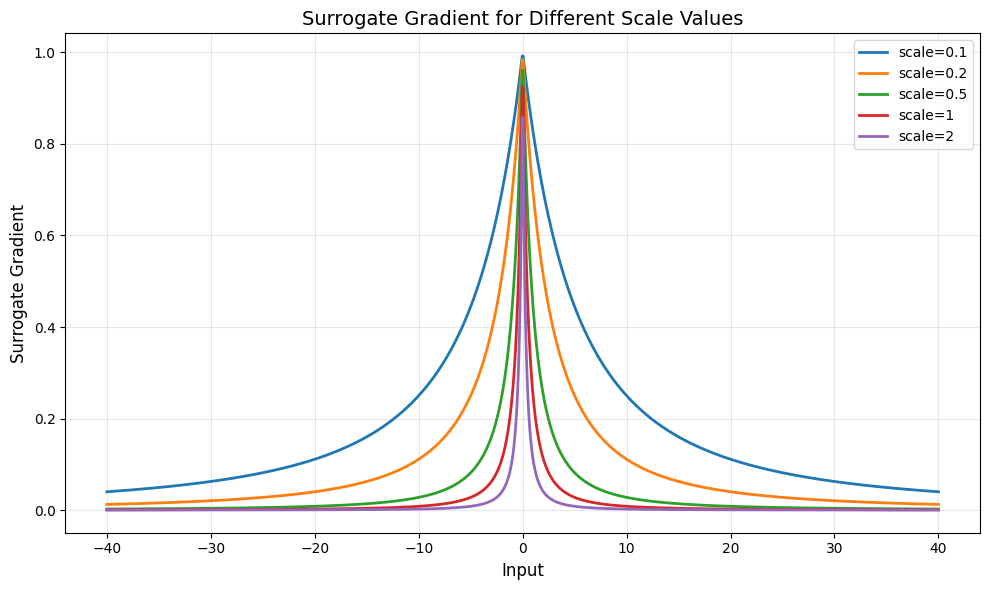

In [5]:
# Create a range of input values
input_values = torch.linspace(-40, 40, 1000)

# Scale values to plot
scales = [0.1, 0.2, 0.5, 1, 2]

# Plot the gradient for each scale
plt.figure(figsize=(10, 6))

for scale in scales:
    # Compute the surrogate gradient: 1 / (scale * |input| + 1)^2
    gradient = 1.0 / (scale * torch.abs(input_values) + 1.0) ** 2
    plt.plot(
        input_values.numpy(), gradient.numpy(), label=f"scale={scale}", linewidth=2
    )

plt.xlabel("Input", fontsize=12)
plt.ylabel("Surrogate Gradient", fontsize=12)
plt.title("Surrogate Gradient for Different Scale Values", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()